# <span style="color:red">此為 CNN+VAE 的初步延伸，但由於內容不完整，因此不包含在正式課程中，亦無錄製相關影片，若同學有興趣，可參酌學習。</span>

# 單元 07-2. 使用 CNN 建立 Variational Autoencoder

本單元的練習中，我們將帶領各位練習建立 CNN 版本的 VAE。

## 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras import metrics
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


讀取 MNIST 手寫辨識資料

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

## 2. 建立 VAE 的初始準備

In [6]:
x = Input(shape=(28, 28, 1))

In [7]:
enc_1 = Conv2D(2, 3, activation='relu')
enc_2 = Conv2D(2, 3, activation='sigmoid')

z_mean = GlobalAveragePooling2D()(enc_1(x))
z_log_var = GlobalAveragePooling2D()(enc_2(x))

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0.,
                              stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

從 `z` 將圖還原的時候，我們採用與 fully-connected VAE 相同的方式還原成一 `784` 維的向量，再 `reshape` 成 `(28, 28, 1)` 的圖片

In [10]:
dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

dec_x = dec_2(z)
x_reconstructed = dec_1(dec_x)
x_reconstructed = Reshape((28, 28, 1))(x_reconstructed)

In [11]:
VAE = Model(x, x_reconstructed)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 26, 26, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2)            0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
global_ave

### 3.3 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

In [12]:
def vae_loss(x, x_recon):  
    
    recovery_loss = 784 * metrics.binary_crossentropy(K.flatten(x), K.flatten(x_recon))
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

### 3.4 訓練 VAE

In [13]:
VAE.compile(loss=vae_loss, optimizer='Nadam')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# VAE.fit(x_train, x_train, batch_size=32, epochs=100)

In [15]:
# VAE.save_weights('VAE_handwriting_model_weights.h5')
# VAE.load_weights('VAE_handwriting_model_weights.h5')

### 3.5 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

In [16]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 2)         20        
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2)                 0         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [17]:
h_input = Input(shape=(2,))

Decoder = Model(h_input, Reshape((28, 28, 1))(dec_1(dec_2(h_input))))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [18]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))







第 51913 圖的 latent 表示為 [[27.029657   3.3797805]]


In [19]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

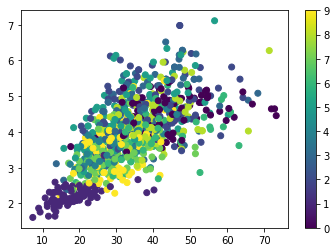

In [20]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices])
plt.colorbar()
plt.show()

接著，我們進行 Decoder 的視覺化呈現。

In [21]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [22]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

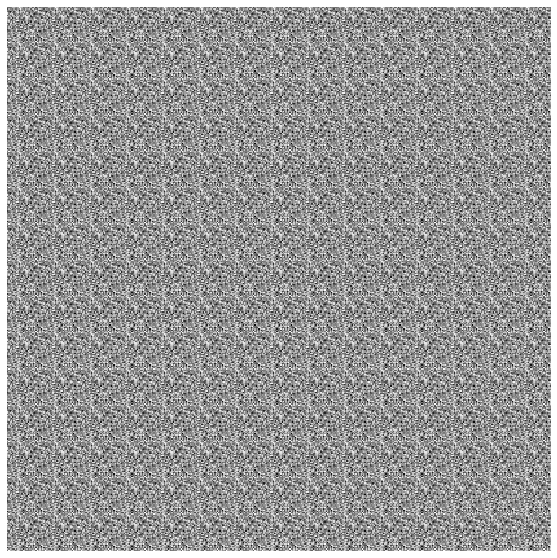

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

### 3.6 討論

* 從 Decoder 視覺化可看出，將 `z` 透過全連接層 (fully-connected) 再 reshape 成圖片，其還原的結果並不那麼好，那是否有其他的方式可以改進呢？

答案是有的，對應於卷積 (convolutinal layer)，有所謂的反卷積 (deconvolutinal OR convolutinal transpose)。

一般針對圖片建構的 convolutional VAE，會在 Decoder 的部分使用反卷積，其還原效果會較使用全連接層來的好。

由於反卷積的解釋超出本課程的範圍，但網路上其實有許多豐富的解釋與視覺化呈現，若有興趣的同學們可以上網搜尋相關技術。